# Interactive Notebook for FMD KPIs

## Setup

In [1]:
# workhorse modules
import pandas as pd
from datetime import timedelta, datetime
from pathlib import Path
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# local utility functions
from utils.general_utils import (
    add_fiscal_year,
    compute_is_on_time,
    set_pd_params,
    choose_pms_or_cms,
    compute_pm_cm,
    compute_pm_cm_by_month,
    compute_kpi_table,
    compute_kpi_table_by_month,
)
from utils.vis_utils import set_plot_params, pointplot_with_barplot

In [2]:
set_pd_params()
set_plot_params(12, 6)
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
scorecard_path = Path.cwd() / "data" / "scorecard_data.pkl"
wr_tidy = pd.read_pickle(scorecard_path)

In [4]:
# drop rows that were canceled
cond_valid = ~wr_tidy["status"].isin(["Can", "Rej", "R"])

wr_valid = wr_tidy[cond_valid]

print(
    f"By dropping canceled and rejected work orders, we have removed {len(wr_tidy) - len(wr_valid):,} rows."
)

By dropping canceled and rejected work orders, we have removed 4,029 rows.


## Decisions

### Decide on what basis to assign fiscal year
Use the dropdown menu to decide on what basis to assign the fiscal year. 

In [29]:
wr_fy_widget = interactive(
    add_fiscal_year,
    assign_fy_on=["requested", "completed", "closed"],
    df=fixed(wr_valid),
)
wr_fy_widget

interactive(children=(Dropdown(description='assign_fy_on', index=2, options=('requested', 'completed', 'closed…

In [30]:
fy_assignment = wr_fy_widget.children[0].value
wr_fy = wr_fy_widget.result

### Decide whether to look at PMs or CMs

In [31]:
wr_typed_widget = interactive(
    choose_pms_or_cms,
    selection=["PMs", "CMs"],
    df=fixed(wr_fy),
)

wr_typed_widget

interactive(children=(Dropdown(description='selection', options=('PMs', 'CMs'), value='PMs'), Output()), _dom_…

In [32]:
selection = wr_typed_widget.children[0].value
wr_typed = wr_typed_widget.result
print(f"The filtered {selection} dataframe has {len(wr_typed):,} rows.")

The filtered CMs dataframe has 94,452 rows.


### Check out the most numerous problem types

In [33]:
wr_typed["problem_type"].value_counts().nlargest(10)

HVAC              14057
OTHER             13944
SERV/CUSTODIAL     8189
ELEC/LIGHT         5782
PLUMB/OTHER        4112
_DELIVERY          3981
DOOR               3960
ELEC/GENERAL       3607
LOCK               2997
PLUMB/UNCLOG       2912
Name: problem_type, dtype: int64

### Add a column for "Is on time"

In [34]:
# add "is_on_time" column with performance data
wrs_on_time = wr_typed.dropna(subset=["days_to_completion", "benchmark"])
wrs_on_time["is_on_time"] = compute_is_on_time(
    wrs_on_time["days_to_completion"], wrs_on_time["benchmark"]
)

## Compute the KPI and visualize

### Aggregate by the the fiscal year

In [35]:
pm_compliance = compute_kpi_table(
    wrs_on_time,
    f"percent_{selection}_on_time",
    f"total_{selection}",
    grouping_var="fiscal_year",
)
pm_compliance

,percent_CMs_on_time,total_CMs
fiscal_year,,
2014,75.36,9849
2015,76.56,13825
2016,77.98,15312
2017,69.85,15052
2018,68.21,12943
2019,50.27,9012
2020,47.87,7668
2021,42.18,4289


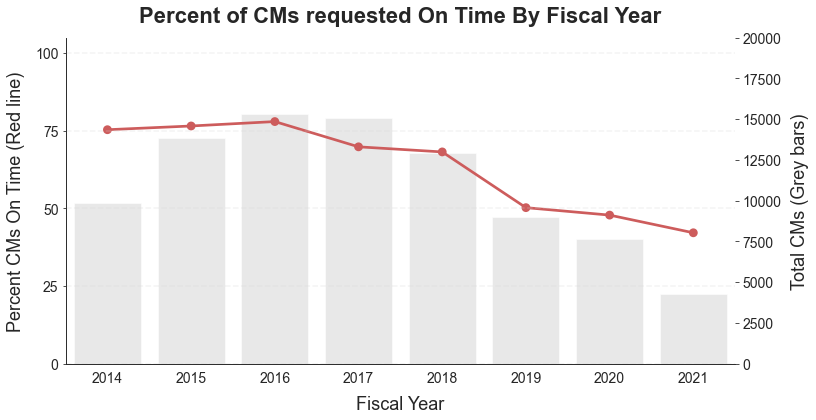

In [37]:
pointplot_with_barplot(
    pm_compliance,
    x=pm_compliance.index,
    point_y=f"percent_{selection}_on_time",
    bar_y=f"total_{selection}",
    ymax_bar=20_000,
    xlabel="Fiscal Year",
    ylabel_point=f"Percent {selection} On Time (Red line)",
    ylabel_bar=f"Total {selection} (Grey bars)",
    title=f"Percent of {selection} {fy_assignment} On Time By Fiscal Year",
)